In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

#plt.style.use('fivethirtyeight')

/root/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n10000.p'

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")

# Load Data

### Output

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:
train_fraction = 0.8

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [6]:
epochs = 9000
# X_train = X_train.todense()
# X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=50,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [7]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=0.1,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe73523d128>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000,

# Training



In [8]:
tf.set_random_seed(42)

    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",#loss
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=3000)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Saving checkpoints for 0 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 2.0256464, step = 1
INFO:tensorflow:global_step/sec: 119.995
INFO:tensorflow:loss = 1.746604, step = 101 (0.834 sec)
INFO:tensorflow:global_step/sec: 129.445
INFO:tensorflow:loss = 1.572084, step = 201 (0.773 sec)
INFO:tensorfl

INFO:tensorflow:global_step/sec: 134.088
INFO:tensorflow:loss = 0.5209095, step = 2801 (0.745 sec)
INFO:tensorflow:global_step/sec: 134.735
INFO:tensorflow:loss = 0.538098, step = 2901 (0.743 sec)
INFO:tensorflow:Saving checkpoints for 3000 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-06-01:38:33
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-06-01:38:35
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.82467914, global_step = 3000, loss = 0.5300811
INFO:tensorflow:Validation (step 3000): loss = 0.5300811, accuracy = 0.82467914, global_step = 3000
INFO:tensorflow:global_step/sec: 37.2936
INFO:tensorflow:loss = 0.59112436, step = 3001 (2.680 sec)
INFO:tensorflow:global_step/sec: 133.737
INFO:tensorflow:loss = 0.40172508, step = 3101 (0.748 sec)
INFO:t

INFO:tensorflow:global_step/sec: 131.856
INFO:tensorflow:loss = 0.37012234, step = 6301 (0.758 sec)
INFO:tensorflow:global_step/sec: 132.705
INFO:tensorflow:loss = 0.17931396, step = 6401 (0.754 sec)
INFO:tensorflow:Saving checkpoints for 6500 into ../models/test/model.ckpt.
INFO:tensorflow:Starting evaluation at 2018-10-06-01:39:13
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-6500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-06-01:39:15
INFO:tensorflow:Saving dict for global step 6500: accuracy = 0.8331638, global_step = 6500, loss = 0.48514238
INFO:tensorflow:Validation (step 6500): loss = 0.48514238, accuracy = 0.8331638, global_step = 6500
INFO:tensorflow:global_step/sec: 34.1778
INFO:tensorflow:loss = 0.56438804, step = 6501 (2.926 sec)
INFO:tensorflow:global_step/sec: 130.298
INFO:tensorflow:loss = 0.6204541, step = 6601 (0.768 sec)
INFO

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-9000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


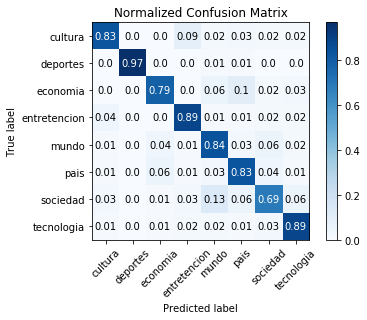

## Accuracy in test: 88.07051335734025 

In [10]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

In [ ]:
from itertools import islice, chain

a=islice('ABCDEFG', 1, None)

print("asd")
for k in a:
    print(k)
   

In [ ]:
a=[1 ,2 ,3 ,4 ,5 ,6, 7]

In [ ]:
a[5:]

In [ ]:
def input_fn_evaluate1():
    dataset = {'x': tf.constant(X_test[0:25000,:].todense() )}    
    return dataset

pred_test1 = classifier.predict_classes(input_fn=input_fn_evaluate1)

def input_fn_evaluate2():
    dataset = {'x': tf.constant(X_test[25000:,:].todense() )}    
    return dataset
pred_test2 = classifier.predict_classes(input_fn=input_fn_evaluate2)


In [ ]:
y_test_hat1 = np.asarray([x.decode('UTF-8') for x in list(pred_test1)])
y_test_hat2 = np.asarray([x.decode('UTF-8') for x in list(pred_test2)])


In [ ]:
y_test_hat = np.concatenate((y_test_hat1, y_test_hat2), axis=0)

In [ ]:
y_test_hat.shape

In [ ]:
#X_test = X_test.todense()

y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))